# Exercise - GANs for learning distributions

1. You are curious if GANs are able to model just *any* multivariate normal distribution, so you decide to try a new dimensionality, mean, and standard deviation, and otherwise replicate the study from the slides.
1. As you mutter "very well, it might work, but we also start with a standard normal - in reality we are newer so close to the true distribution to start off!", you decide to model the noise from another distribution (such as the uniform distribution). Are you still able to model the true distribution? 

**Notes**: In this notebook, I have made a few choices (listed below). You **do not** have to follow those - you can use other distributions, dimensionalities, means, and standard deviations, if you like.
1. The distribution to model is now the 20D normal distribution with mean $-5$ and standard deviation $-2$.
1. The noise distribution for **2** is now the 20D uniform distribution (in the range $[0,1)$).

**Hint**: Consider looking at https://www.tensorflow.org/tutorials/generative/dcgan, as they go through some of the same steps.

**See slides for more details!**

# Setup

You do not (but are of course welcome to) have to change any of the setup code.

Note that we use 1 to indicate "real" data and zero to indicate "fake" data for the discriminator.

In the loss of the generator, this is "reversed", i.e. fake data is 1. This is since it needs to learn to create fake data that the generator believes is real.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

In [2]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def get_stats():
    noise = tf.random.normal([1000, 20]) # standard normal
    real = tf.random.normal([1000, 20], mean=-5, stddev=2) # to non-standard normal
    
    fake = generator.predict(noise)
    
    discr_real_pred = tf.nn.sigmoid(discriminator.predict(real)).numpy()
    discr_fake_pred = tf.nn.sigmoid(discriminator.predict(fake)).numpy()
    
    acc_real = np.mean(discr_real_pred >= 0.5)
    acc_fake = np.mean(discr_fake_pred < 0.5)
                                    
    return np.mean(fake), np.sqrt(np.var(fake)), acc_real, acc_fake

# Exercise 1

You are curious if GANs are able to model just *any* multivariate normal distribution, so you decide to try a new dimensionality, mean, and standard deviation, and otherwise replicate the study from the slides.

Let us start by defining the generator and discriminator, as well as their optimizers.

In [3]:
generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=(20,)) # 20 since a 20D normal distribution
])

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(1),
])

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Let us proceed by defining the training-step function we want to use.

In [4]:
@tf.function
def train_step():
    noise = tf.random.normal([32, 20]) # 20D multivariate standard normal..batch-size=32, 
    real = tf.random.normal([32, 20], mean=-5, stddev=2) # REMEMBER THIS MUST MATCH!

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(real, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Now, let us train the model!

In [5]:
results = [('Before training', *get_stats())]

for epoch in range(1, 20 + 1):
    print(f'Starting epoch: {epoch}.')
    
    for _ in range(5000): # steps pr epoch
        train_step()

    results.append((epoch, *get_stats()))

results_df = pd.DataFrame(results, columns=['Epoch', 'Mean', 'Std. Dev.', 'Acc., real', 'Acc., fake'])

32/32 [==============================] - 0s 577us/step
Starting epoch: 1.
32/32 [==============================] - 0s 601us/step
Starting epoch: 2.
32/32 [==============================] - 0s 581us/step
Starting epoch: 3.
32/32 [==============================] - 0s 1ms/step
Starting epoch: 4.
32/32 [==============================] - 0s 596us/step
Starting epoch: 5.
32/32 [==============================] - 0s 455us/step
Starting epoch: 6.
32/32 [==============================] - 0s 550us/step
Starting epoch: 7.
32/32 [==============================] - 0s 581us/step
Starting epoch: 8.
32/32 [==============================] - 0s 710us/step
Starting epoch: 9.
32/32 [==============================] - 0s 645us/step
Starting epoch: 10.
32/32 [==============================] - 0s 613us/step
Starting epoch: 11.
32/32 [==============================] - 0s 504us/step
Starting epoch: 12.
32/32 [==============================] - 0s 581us/step
Starting epoch: 13.
32/32 [=============================

Finally, let us create plots like in the slides to check that everything worked.

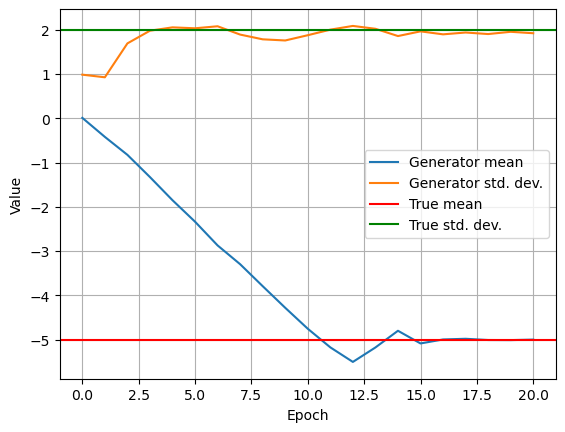

In [6]:
plt.plot(results_df['Mean'], label='Generator mean')
plt.plot(results_df['Std. Dev.'], label='Generator std. dev.')
plt.axhline(-5, color='r', label='True mean')
plt.axhline(2, color='g', label='True std. dev.')
plt.grid()
plt.legend()
plt.xlabel('Epoch'),
plt.ylabel('Value')
plt.show()

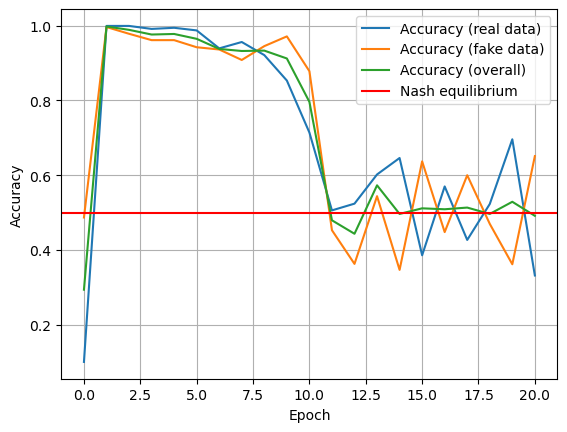

In [7]:
plt.plot(results_df['Acc., real'], label='Accuracy (real data)')
plt.plot(results_df['Acc., fake'], label='Accuracy (fake data)')
plt.plot(results_df[['Acc., real', 'Acc., fake']].mean(axis=1), label='Accuracy (overall)')
plt.axhline(0.5, color='r', label='Nash equilibrium')
plt.grid()
plt.legend()
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.show()

# Exercise 2

As you mutter "very well, it might work, but we also start with a standard normal - in reality we are newer so close to the true distribution to start off!", you decide to model the noise from another distribution (such as the uniform distribution). Are you still able to model the true distribution? 

To solve this exercise, we must:
1. Create a new generator and discriminator (including optimizers).
1. Create a new get_stats function to use another noise distribution.
1. Create a new train_step function to use the new noise distribution.
1. And finally train!

Step 1: New generator and discriminator.

In [8]:
generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(20)
])

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(1),
])

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Step 2: New get_stats.

In [9]:
def get_stats():
    noise = tf.random.uniform([1000, 20]) # uniform
    real = tf.random.normal([1000, 20], mean=-5, stddev=2) # to non-standard normal
    
    fake = generator.predict(noise)
    
    discr_real_pred = tf.nn.sigmoid(discriminator.predict(real)).numpy()
    discr_fake_pred = tf.nn.sigmoid(discriminator.predict(fake)).numpy()
    
    acc_real = np.mean(discr_real_pred >= 0.5)
    acc_fake = np.mean(discr_fake_pred < 0.5)
                                    
    return np.mean(fake), np.sqrt(np.var(fake)), acc_real, acc_fake

Step 3: New train_step.

In [10]:
@tf.function
def train_step():
    noise = tf.random.uniform([32, 20]) # uniform
    real = tf.random.normal([32, 20], mean=-5, stddev=2)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(real, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Step 4: Let us train.

In [11]:
results = [('Before training', *get_stats())]

for epoch in range(1, 40 + 1):
    print(f'Starting epoch: {epoch}.')
    
    for _ in range(5000): # steps pr epoch
        train_step()

    results.append((epoch, *get_stats()))

results_df = pd.DataFrame(results, columns=['Epoch', 'Mean', 'Std. Dev.', 'Acc., real', 'Acc., fake'])

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 644us/step
Starting epoch: 1.
32/32 [==============================] - 0s 613us/step
Starting epoch: 2.
32/32 [==============================] - 0s 548us/step
Starting epoch: 3.
32/32 [==============================] - 0s 590us/step
Starting epoch: 4.
32/32 [==============================] - 0s 516us/step
Starting epoch: 5.
32/32 [==============================] - 0s 581us/step
Starting epoch: 6.
32/32 [==============================] - 0s 581us/step
Starting epoch: 7.
32/32 [==============================] - 0s 645us/step
Starting epoch: 8.
32/32 [==============================] - 0s 645us/step
Starting epoch: 9.
32/32 [==============================] - 0s 581us/step
Starting epoch: 10.
32/32 [==============================] - 0s 612us/step
Starting epoch: 11.
32/32 [==============================] - 0s 516us/step
Starting epoch: 12.
32/32 [==============================] - 0s 613us/step
Starting epoch: 13.
32/32 [===========================

And finally, let us do the plots!

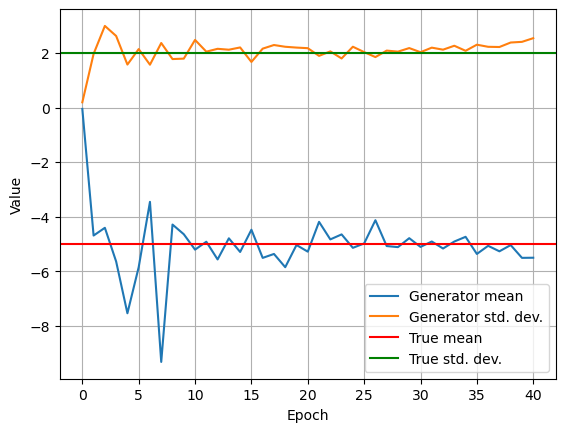

In [12]:
plt.plot(results_df['Mean'], label='Generator mean')
plt.plot(results_df['Std. Dev.'], label='Generator std. dev.')
plt.axhline(-5, color='r', label='True mean')
plt.axhline(2, color='g', label='True std. dev.')
plt.grid()
plt.legend()
plt.xlabel('Epoch'),
plt.ylabel('Value')
plt.show()

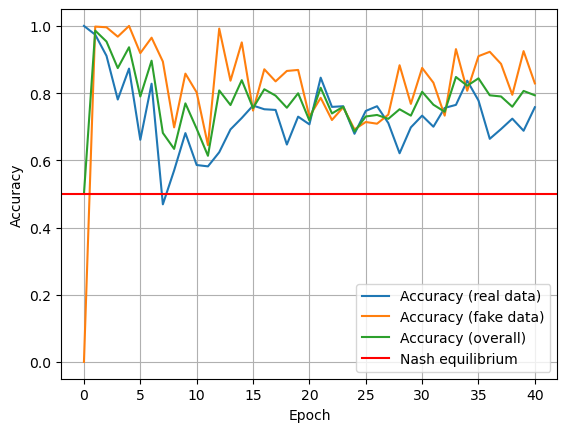

In [13]:
plt.plot(results_df['Acc., real'], label='Accuracy (real data)')
plt.plot(results_df['Acc., fake'], label='Accuracy (fake data)')
plt.plot(results_df[['Acc., real', 'Acc., fake']].mean(axis=1), label='Accuracy (overall)')
plt.axhline(0.5, color='r', label='Nash equilibrium')
plt.grid()
plt.legend()
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.show()

It seems to not quite have converged yet, but be on its way. Probably train for longer!